In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(writexl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [2]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
beeswarm_results %>% head

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,3.786202,13.32846,28.65605,1.203665e-05,0.002250854,127,0.002451558,pos,Agrp,1,⋯,98.9882688,1.691103e-10,1.756868e-09,1.521349e-09,pos,1,89,neuron,3.216700,-13.25480
2,2.942268,13.13703,22.75446,5.730611e-05,0.003109848,18,0.003257913,pos,Agrp,1,⋯,18.4248083,2.056099e-04,5.340146e-04,4.726740e-04,pos,1,85,neuron,3.556380,-13.47460
3,3.762935,13.18959,23.36177,4.837156e-05,0.003109848,19,0.003257913,pos,Agrp,1,⋯,74.0789103,3.367667e-09,1.880265e-08,1.715807e-08,pos,1,80,neuron,3.986626,-12.99642
4,3.207390,13.03162,21.31327,8.646514e-05,0.003109848,41,0.003257913,pos,Agrp,1,⋯,12.4463870,1.529748e-03,2.466059e-03,2.251006e-03,pos,1,79,neuron,3.500047,-14.23880
5,2.281578,12.96570,21.49272,8.208911e-05,0.003109848,90,0.003257913,pos,Agrp,1,⋯,0.9013692,3.508883e-01,3.645340e-01,3.606322e-01,none,1,80,neuron,3.647344,-14.31736
6,4.542154,13.16189,22.97615,9.978122e-05,0.003109848,144,0.003257913,pos,Agrp,1,⋯,97.0751771,2.718156e-09,1.588422e-08,1.451895e-08,pos,1,76,neuron,2.933367,-13.35223


In [3]:
beeswarm_results %>% head %>% print

     logFC   logCPM        F       PValue         FDR Nhood  SpatialFDR
1 3.786202 13.32846 28.65605 1.203665e-05 0.002250854   127 0.002451558
2 2.942268 13.13703 22.75446 5.730611e-05 0.003109848    18 0.003257913
3 3.762935 13.18959 23.36177 4.837156e-05 0.003109848    19 0.003257913
4 3.207390 13.03162 21.31327 8.646514e-05 0.003109848    41 0.003257913
5 2.281578 12.96570 21.49272 8.208911e-05 0.003109848    90 0.003257913
6 4.542154 13.16189 22.97615 9.978122e-05 0.003109848   144 0.003257913
  polarity labels labels_fraction                      comparison restored
1      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
2      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
3      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
4      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
5      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5    FALSE
6      pos   Agrp               1 Day5.obob5v5

In [4]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, fgf1_grouping) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(fgf1_grouping != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(fgf1_grouping = factor(fgf1_grouping, levels = c("pos", "none", "neg")))


In [5]:
saved_levels = final_summary_percent %>% pull(labels) %>% levels

In [6]:
saved_levels

[1] "Astrocytes"          "Htr3b"               "OPC"                
 [4] "Agrp"                "Trh__Lef1"           "Tanycytes"          
 [7] "Oligodendrocytes"    "Ghrh"                "Ppp1r17__Tafa4"     
[10] "Ependymal_cells"     "Sst__Unc13c"         "Tbx19__Pirt"        
[13] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Pomc__Glipr1"       
[16] "Pou6f2__Prkcq__Whrn" "Sst__Pthlh"          "Th__Slc6a3"         
[19] "Arx__Nr5a2"          "Dlk1"                "Endothelial_cells"  
[22] "Esr1"                "Fez1"                "Gpr50__Tac2"        
[25] "Hdc"                 "Lepr15"              "Lepr67"             
[28] "Lepr89"              "Lpar1_oligo"         "Met__Pappa2"        
[31] "Met__Prlh"           "Microglia"           "Nfib_1"             
[34] "Nfib_2"              "Nfib_3"              "Nfix__Nfib"         
[37] "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"    "Npsr1__Epha3"       
[40] "Pomc__Anxa2"         "Pomc__Ttr"           "Ppp1r17"            
[43] "Ppp1r17__Ltbp1"      "Reln__Lef1"          "Sim1"               
[46] "Slc17a6__Trhr"       "Sst__Nts"            "Th__Nfib"           
[49] "Tmem215__Dach2"      "Tmem215__Greb1"      "Trh__Cxcl12"

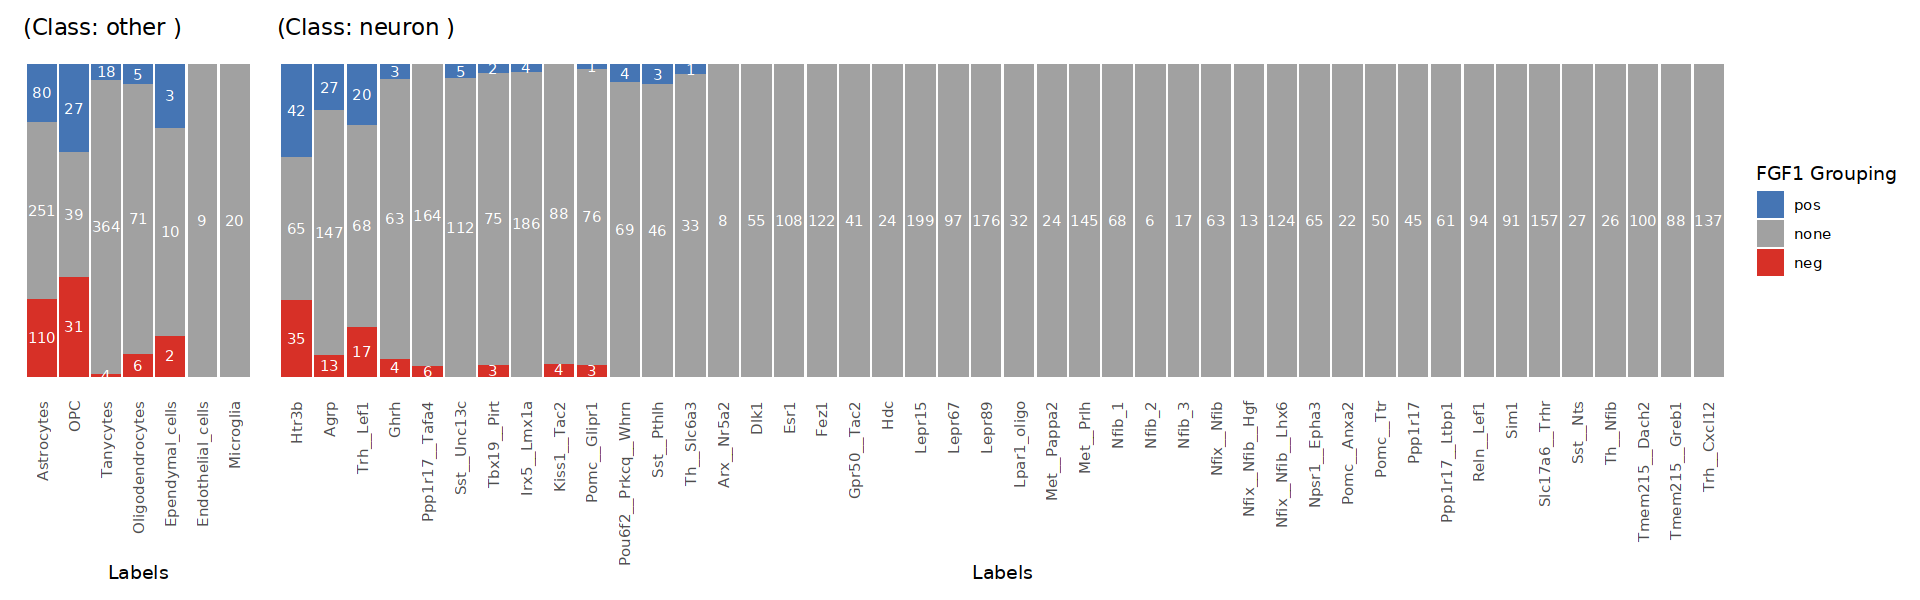

In [7]:
options(repr.plot.width=16, repr.plot.height=5)
# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = fgf1_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 3) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#d73027",
                                   'pos' = "#4575b4")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "FGF1 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot %>% ggsave('nh_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot

In [8]:
beeswarm_results %>% distinct(exact_grouping) %>% print

  exact_grouping
1   pos_restored
2       pos_FGF1
3   neg_restored
4       pos_away
5        neg_BL6
6        pos_BL6
7           none
8       neg_FGF1
9       neg_away


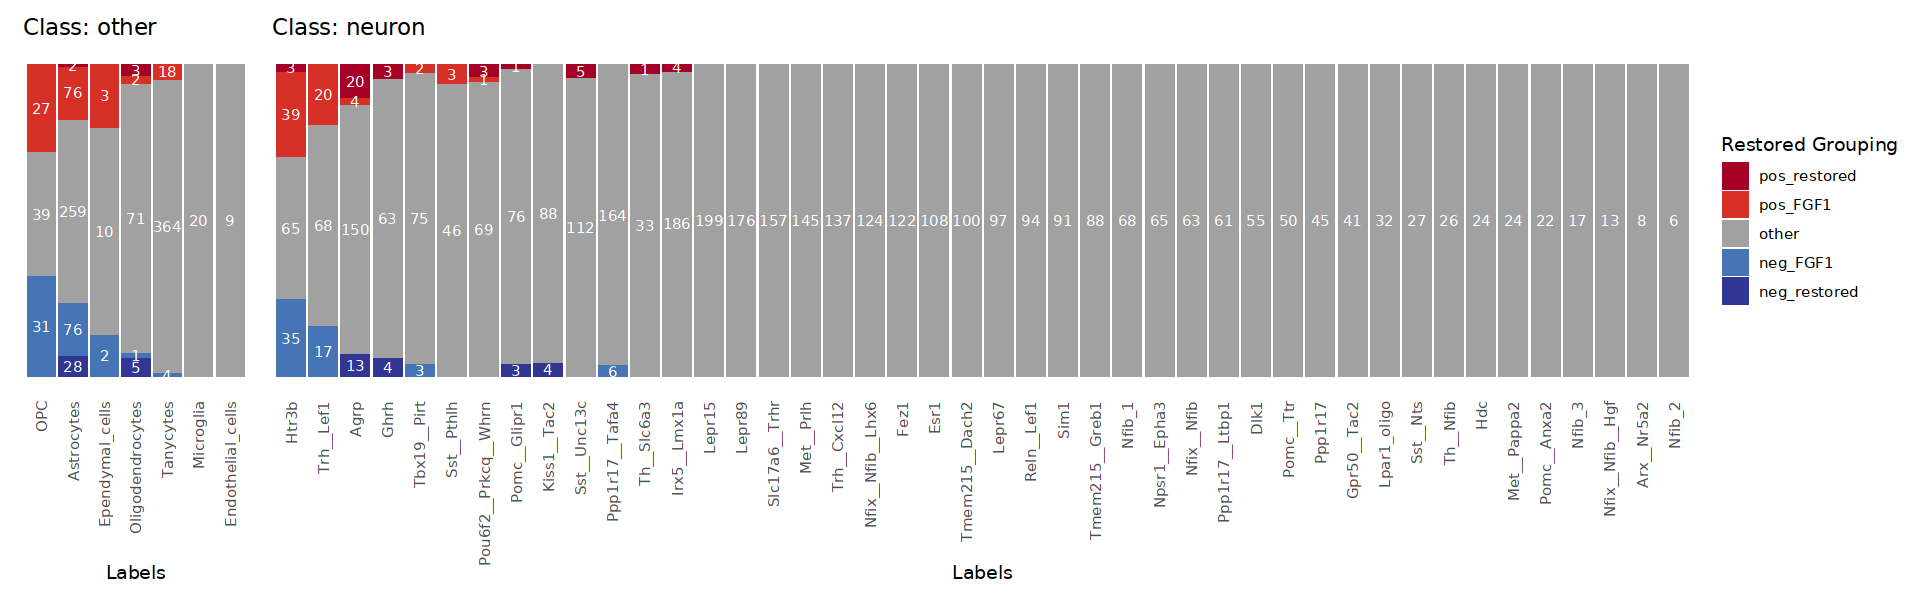

In [9]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
# Step 1: Modify restored_grouping
beeswarm_results <- beeswarm_results %>%
  mutate(restored_grouping = case_when(
    restored_grouping %in% c("pos_restored", "pos_FGF1", "neg_FGF1", "neg_restored") ~ restored_grouping,
    TRUE ~ "other"
  ))

# Step 2: Recalculate summaries and percentages
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, restored_grouping) %>%
  summarise(count = n(), .groups = 'drop')

not_none_summary <- original_summary %>%
  filter(restored_grouping != 'other') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')


# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), desc(total_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))
         
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(not_none_percent = not_none_count/ total_count) %>%
  mutate(restored_grouping = factor(restored_grouping, levels = c("pos_restored", "pos_FGF1", "other", "neg_FGF1", "neg_restored"))) %>%
  arrange(desc(not_none_percent), desc(count), labels)
  
saved_levels = final_summary_percent %>% pull(labels) %>% unique

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels))

# Step 3: Create plots for each class and combine them using patchwork
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = restored_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 3) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c(
        'other' =  "#a1a1a1",
        'neg_FGF1' = "#4575b4",
        'pos_FGF1' = "#d73027",
        'neg_restored' = "#313695",
        'pos_restored' = "#a50026"
      )) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
            axis.ticks = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Percentage",
           fill = "Restored Grouping")
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_fgf1 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot_fgf1

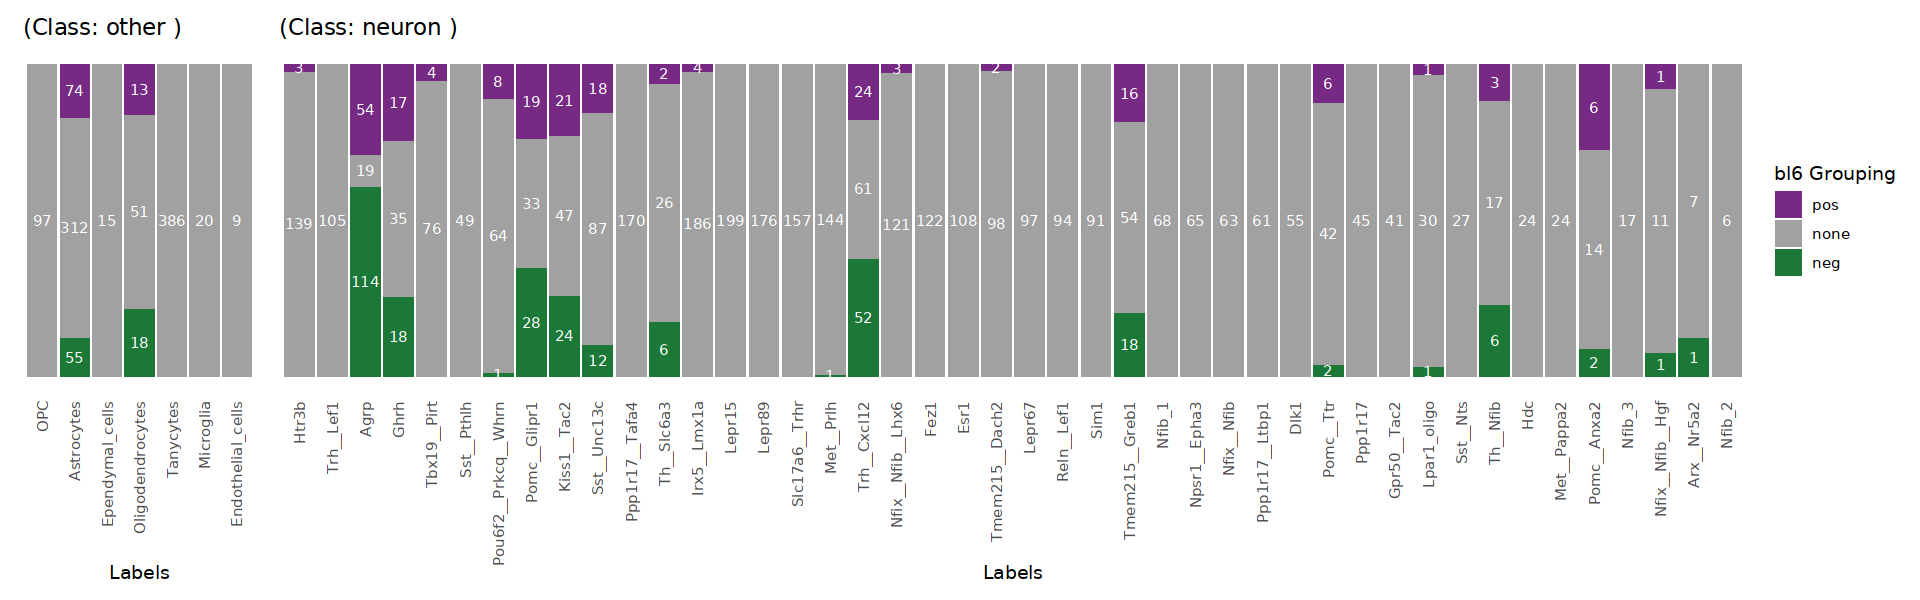

In [10]:
options(repr.plot.width=16, repr.plot.height=5)

beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, polarity_bl6) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(polarity_bl6 != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = saved_levels))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(polarity_bl6 = factor(polarity_bl6, levels = c("pos", "none", "neg"))) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class))


# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = polarity_bl6)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 3) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#1b7837",
                                   'pos' = "#762a83")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "bl6 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_bl6 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect") +
  plot_layout(guides = 'collect')

# Display the combined plot
# combined_plot %>% ggsave('nh_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot_bl6

In [11]:
options(repr.plot.width=16, repr.plot.height=10)
combined_plots = (combined_plot_fgf1 & 
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))
combined_plots = combined_plots + plot_layout(guides = 'collect')



combined_plots %>% ggsave('nh_sum_d5_MAST.pdf', plot = ., width = 16, height=10)

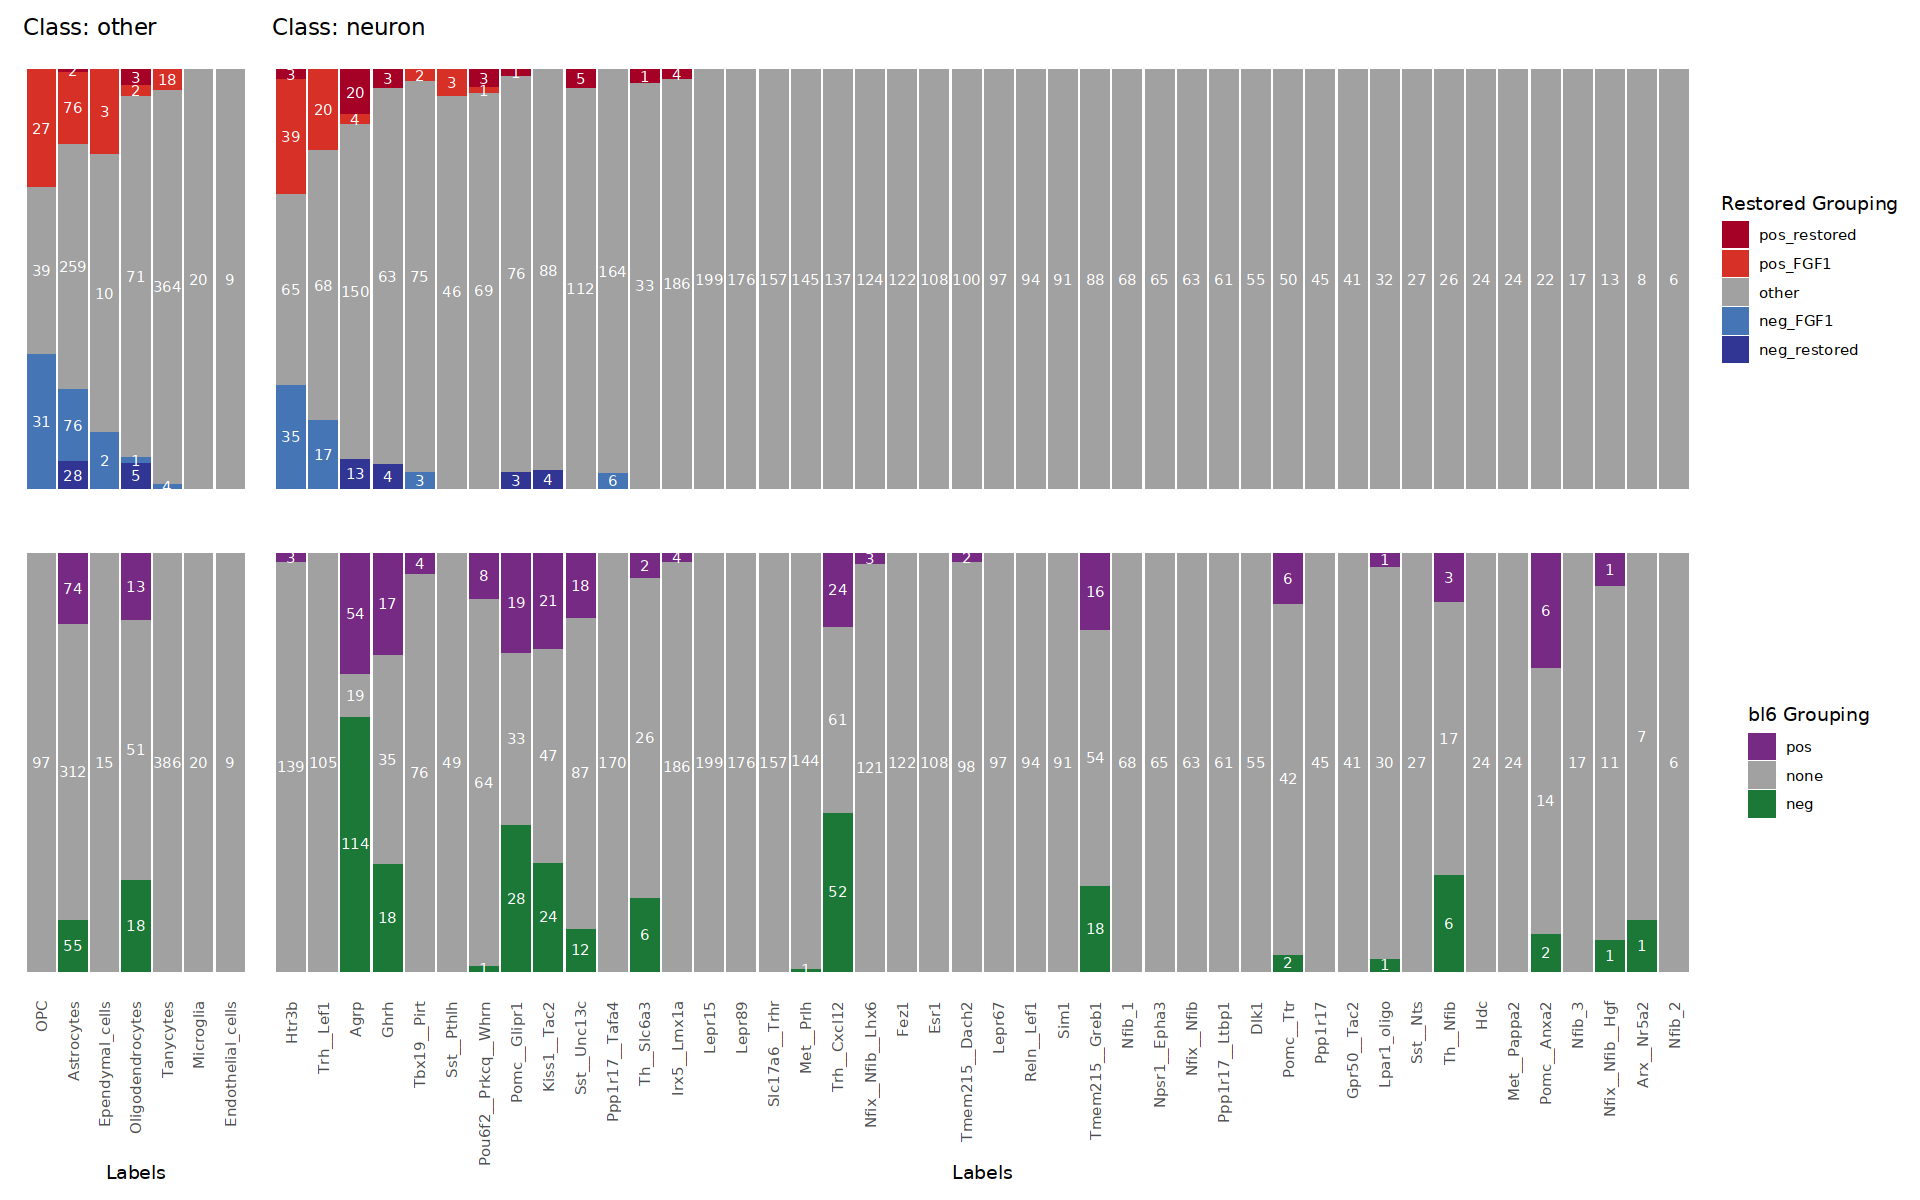

In [12]:
combined_plots

In [13]:
final_summary_percent_d5 = final_summary_percent 
final_summary_percent_d5 %>% write_xlsx('nh_DA_summary_Day5.xlsx')

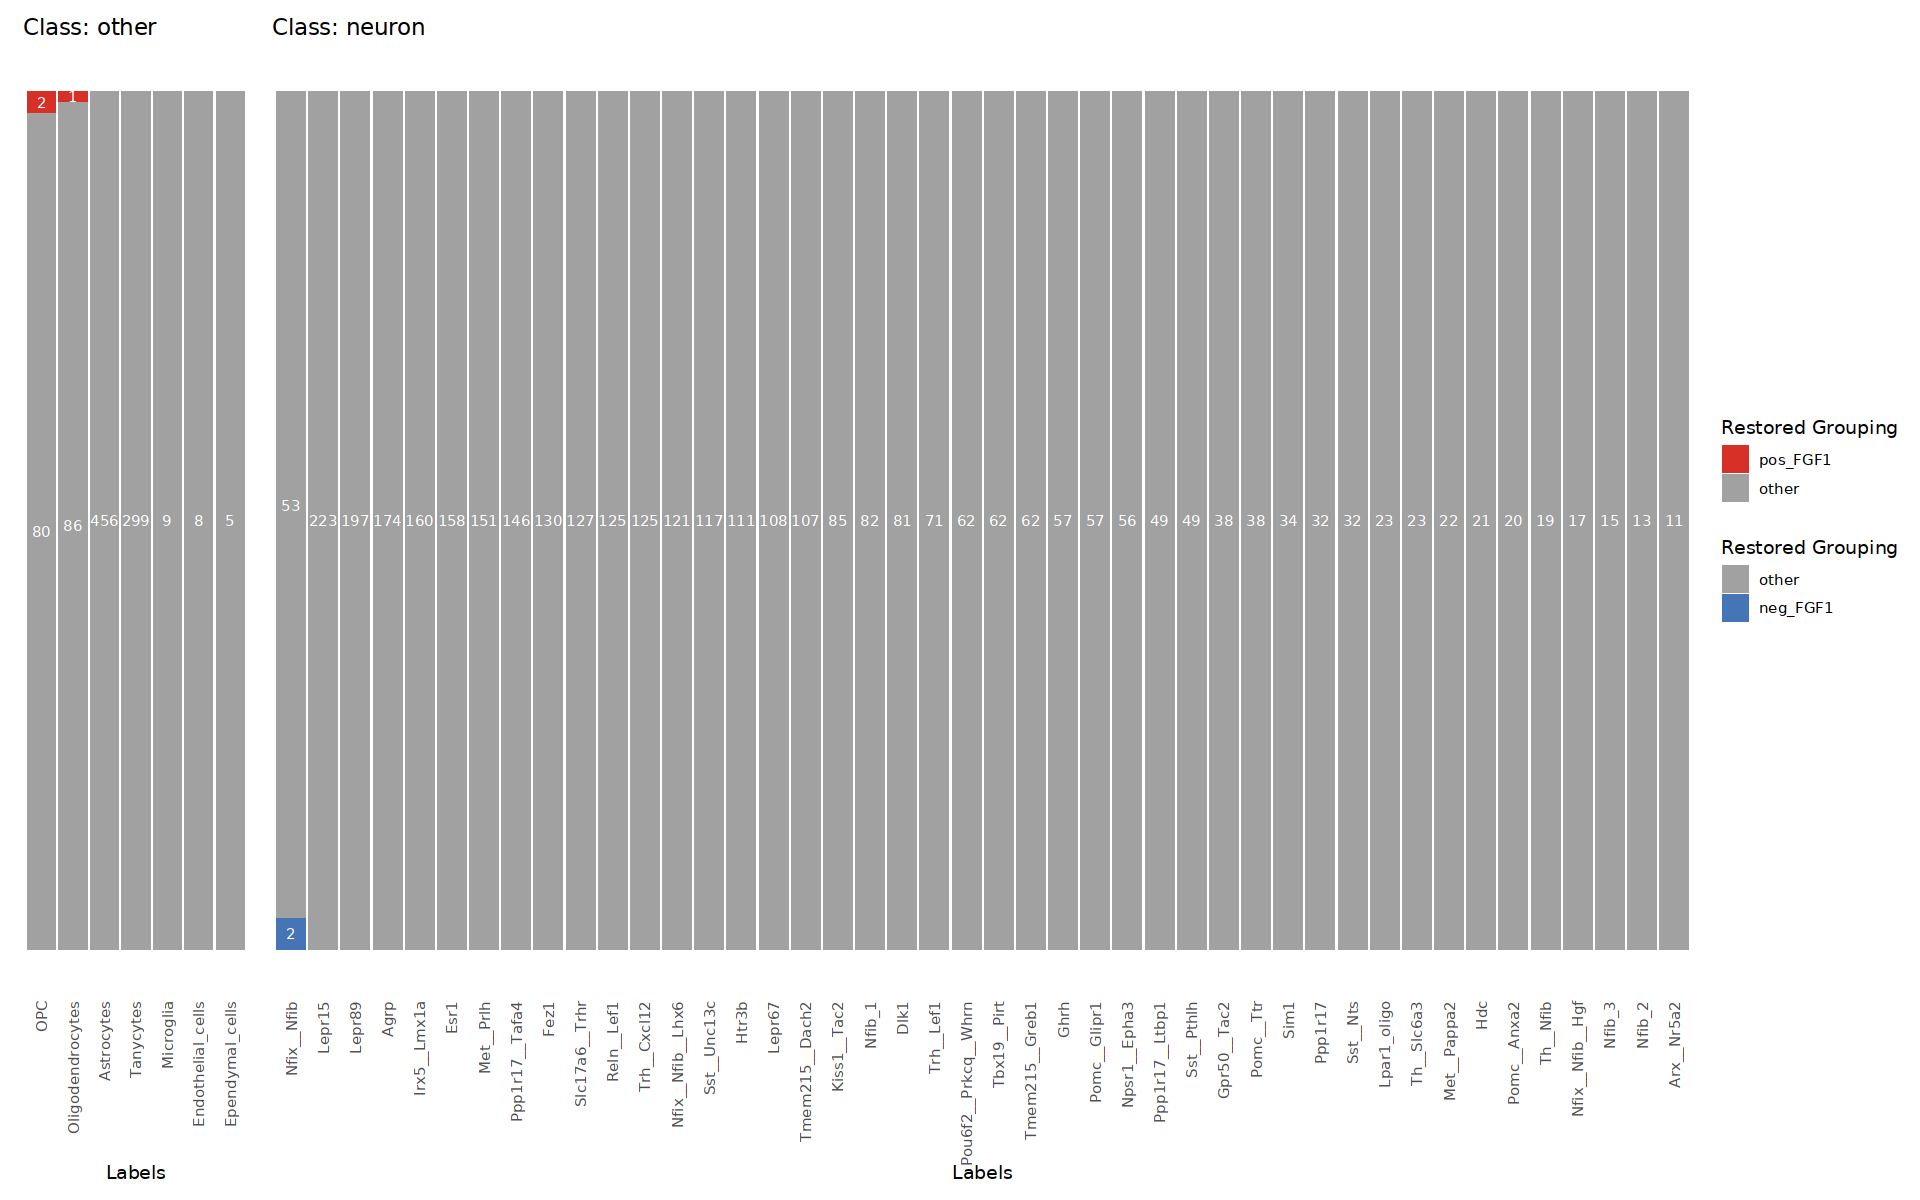

In [14]:
beeswarm_results = qs::qread('beeswarm_da_results_d14_MAST.qs')
# Step 1: Modify restored_grouping
beeswarm_results <- beeswarm_results %>%
  mutate(restored_grouping = case_when(
    restored_grouping %in% c("pos_restored", "pos_FGF1", "neg_FGF1", "neg_restored") ~ restored_grouping,
    TRUE ~ "other"
  ))

# Step 2: Recalculate summaries and percentages
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, restored_grouping) %>%
  summarise(count = n(), .groups = 'drop')

not_none_summary <- original_summary %>%
  filter(restored_grouping != 'other') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')


# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), desc(total_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))
         
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(not_none_percent = not_none_count/ total_count) %>%
  mutate(restored_grouping = factor(restored_grouping, levels = c("pos_restored", "pos_FGF1", "other", "neg_FGF1", "neg_restored"))) %>%
  arrange(desc(not_none_percent), desc(count), labels) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class))
  
saved_levels = final_summary_percent %>% pull(labels) %>% unique

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels))

# Step 3: Create plots for each class and combine them using patchwork
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = restored_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 3) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c(
        'other' =  "#a1a1a1",
        'neg_FGF1' = "#4575b4",
        'pos_FGF1' = "#d73027",
        'neg_restored' = "#313695",
        'pos_restored' = "#a50026"
      )) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
            axis.ticks = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Percentage",
           fill = "Restored Grouping")
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_fgf1 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot_fgf1

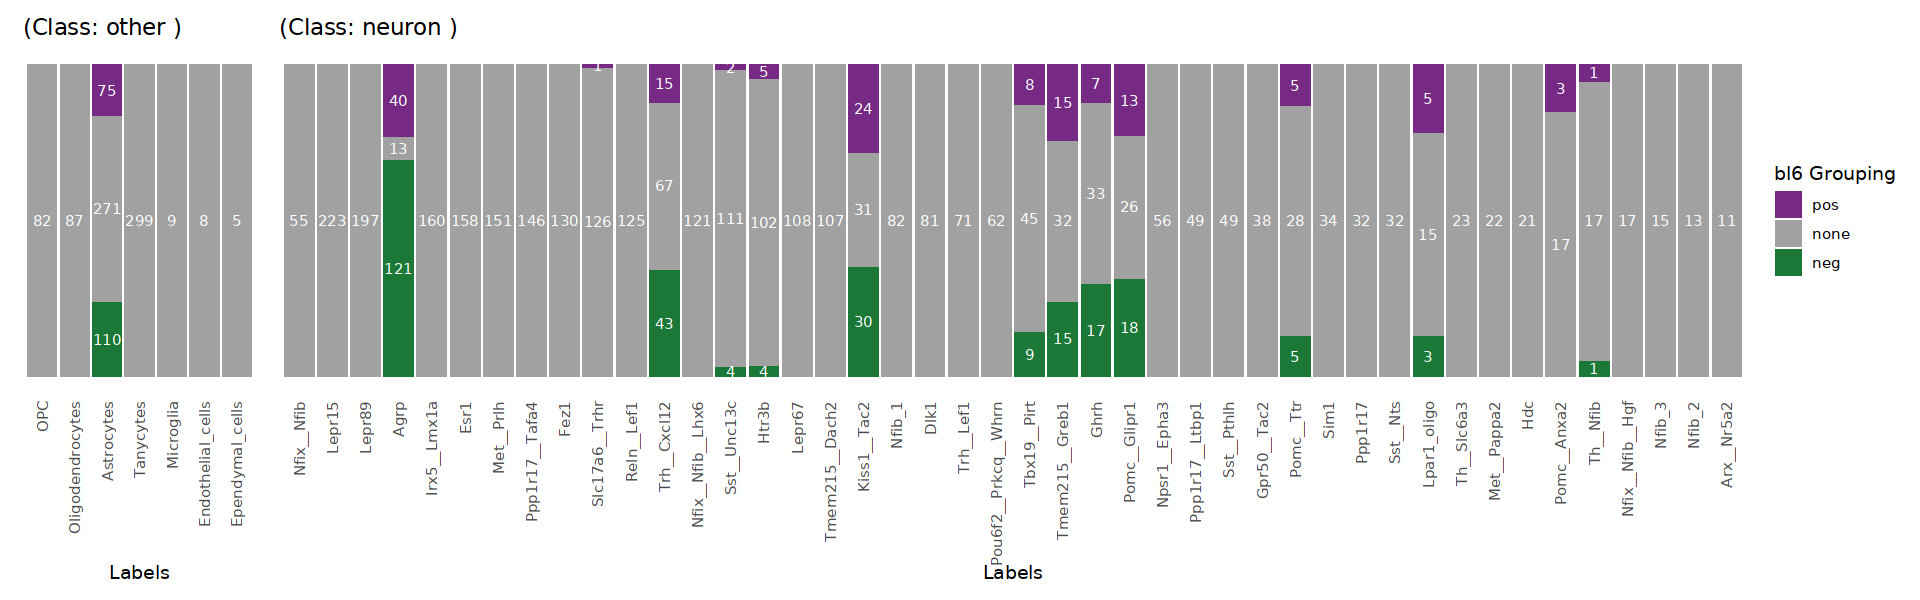

In [15]:
options(repr.plot.width=16, repr.plot.height=5)

beeswarm_results = qs::qread('beeswarm_da_results_d14_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, polarity_bl6) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(polarity_bl6 != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = saved_levels))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(polarity_bl6 = factor(polarity_bl6, levels = c("pos", "none", "neg"))) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class))


# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = polarity_bl6)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 3) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#1b7837",
                                   'pos' = "#762a83")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "bl6 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_bl6 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect") +
  plot_layout(guides = 'collect')

# Display the combined plot
# combined_plot %>% ggsave('nh_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot_bl6

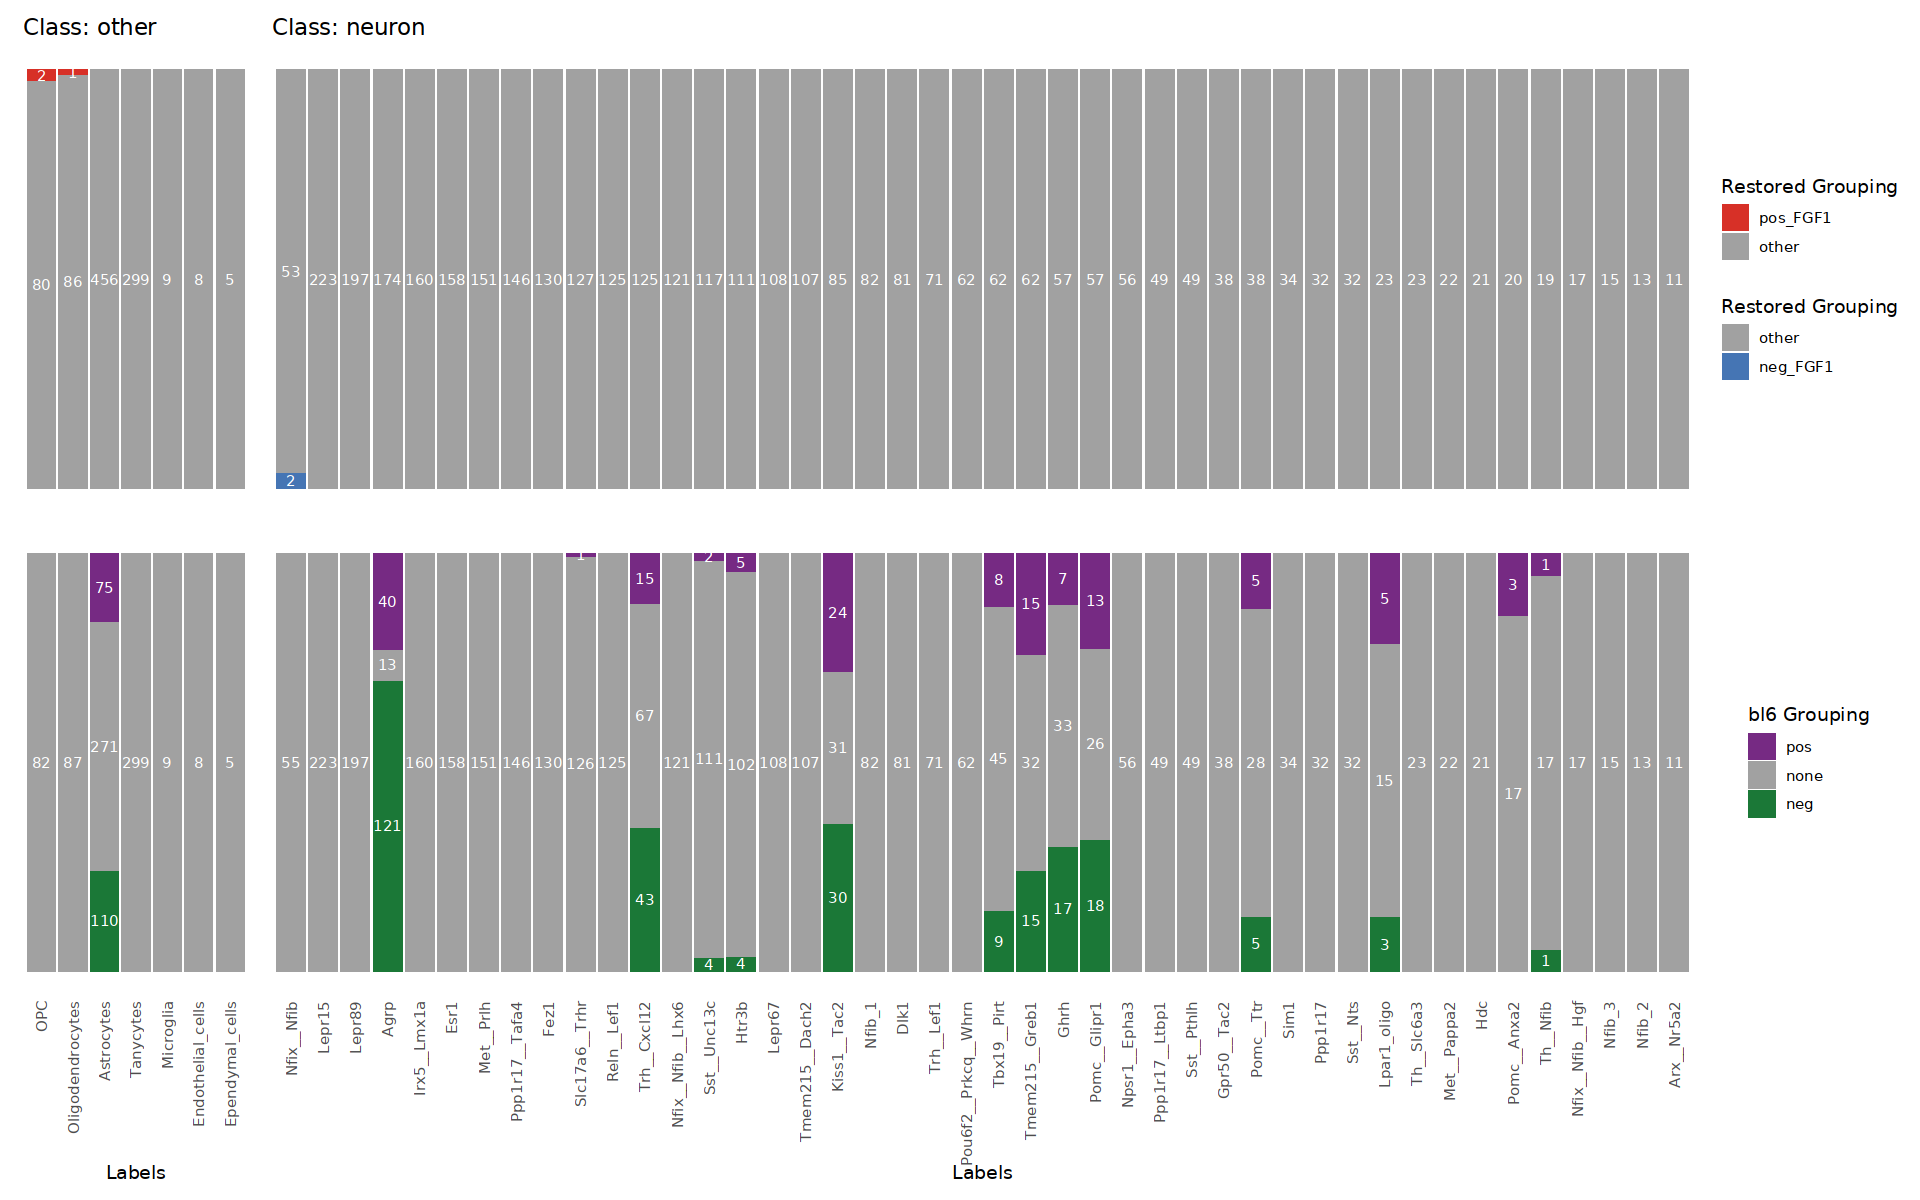

In [16]:
options(repr.plot.width=16, repr.plot.height=10)
combined_plots = (combined_plot_fgf1 & 
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))
combined_plots = combined_plots + plot_layout(guides = 'collect')



combined_plots %>% ggsave('nh_sum_d14_MAST.pdf', plot = ., width = 16, height=10)
combined_plots

In [17]:
final_summary_percent_d14 = final_summary_percent 
final_summary_percent_d14 %>% write_xlsx('nh_DA_summary_Day14.xlsx')

In [18]:
final_summary_percent_d5 - final_summary_percent_d14

ERROR: Error in Ops.data.frame(final_summary_percent_d5, final_summary_percent_d14): ‘-’ only defined for equally-sized data frames


In [ ]:
final_summary_percent_d5 %>% print

In [ ]:
final_summary_percent_d14 %>% print

In [ ]:
combined_data <- full_join(final_summary_percent_d5, final_summary_percent_d14, 
                           by = c("class", "labels", "polarity_bl6"), 
                           suffix = c("_d5", "_d14"))

# Step 2: Calculating the difference
combined_data <- combined_data %>%
  mutate(difference = replace_na(percent_d14, 0) - replace_na(percent_d5, 0))

# Step 3: Select and arrange columns if necessary
result_tibble <- combined_data %>%
  select(class, labels, polarity_bl6, percent_d5, percent_d14, difference)

result_tibble %>% filter(polarity_bl6 != 'none')

In [ ]:
result_tibble %>% write_xlsx('nh_DA_summary_diff_bl6.xlsx')